In [1]:
import os
import json

def combine_json_files(input_dir, output_file):
    metadata_files = [os.path.join(input_dir, file) for file in os.listdir(input_dir)]
    combined_data = []

    for file in metadata_files:
        with open(file, 'r', encoding='EUC-KR') as f:
            data = json.load(f)
            print(f"Loaded {len(data)} entries from {file}")
            combined_data.extend(data)

    with open(output_file, 'w', encoding='EUC-KR') as f:
        json.dump(combined_data, f, ensure_ascii=False, indent=4)
    print(f"Combined data saved to {output_file}")

combine_json_files("/workspace/data/train/label/train", "/workspace/daewoong/face_recognition_emotions/combined_label/combined.json")
combine_json_files("/workspace/data/train/label/val", "/workspace/daewoong/face_recognition_emotions/combined_label/combined_val.json")
combine_json_files("/workspace/data/test/label", "/workspace/daewoong/face_recognition_emotions/combined_label/combined_test.json")


Loaded 1500 entries from /workspace/data/train/label/train/train_sadness.json
Loaded 1500 entries from /workspace/data/train/label/train/train_panic.json
Loaded 1500 entries from /workspace/data/train/label/train/train_anger.json
Loaded 1494 entries from /workspace/data/train/label/train/train_happy.json
Combined data saved to /workspace/daewoong/face_recognition_emotions/combined_label/combined.json
Loaded 300 entries from /workspace/data/train/label/val/val_happy.json
Loaded 300 entries from /workspace/data/train/label/val/val_sadness.json
Loaded 300 entries from /workspace/data/train/label/val/val_anger.json
Loaded 300 entries from /workspace/data/train/label/val/val_panic.json
Combined data saved to /workspace/daewoong/face_recognition_emotions/combined_label/combined_val.json
Loaded 300 entries from /workspace/data/test/label/test_happy.json
Loaded 300 entries from /workspace/data/test/label/test_sadness.json
Loaded 300 entries from /workspace/data/test/label/test_anger.json
Loade

In [2]:
def crop_image(image, box_info):
    minX, minY = int(box_info['minX']), int(box_info['minY'])
    maxX, maxY = int(box_info['maxX']), int(box_info['maxY'])
    
    # 이미지 크롭
    cropped_image = image.crop((minX, minY, maxX, maxY))
    return cropped_image


In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torch

# 라벨 고정 매핑
LABEL_MAPPING = {
    'anger': 0,
    'happy': 1,
    'panic': 2,
    'sadness': 3
}

class CustomEmotionDataset(Dataset):
    def __init__(self, root_dir, metadata_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # 메타데이터 로드
        with open(metadata_file, 'r', encoding='EUC-KR') as f:
            self.metadata = json.load(f)
        
        # 이미지 경로와 라벨 수집
        self.image_paths = []
        self.labels = []
        for emotion_dir in os.listdir(root_dir):
            if emotion_dir not in LABEL_MAPPING:  # 예상된 감정 폴더인지 확인
                print(f"Warning: Skipping unexpected folder '{emotion_dir}'")
                continue
            
            label = LABEL_MAPPING[emotion_dir]
            emotion_path = os.path.join(root_dir, emotion_dir)
            for img_file in os.listdir(emotion_path):
                if label == 2 or label == 3:
                    self.image_paths.append(os.path.join(emotion_path, img_file))
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img_name = os.path.basename(img_path)
        
        image = Image.open(img_path).convert('RGB')
        metadata_filtered = [element for element in self.metadata if element['filename'] == img_name]

        if len(metadata_filtered) == 0:
            age = -1
            gender = -1
            # box_info = metadata_filtered[0]["annot_B"]["boxes"]
            # image = crop_image(image, box_info) 
        else:
            age = metadata_filtered[0]["age"]
            gender = metadata_filtered[0]["gender"]

            if gender == "남":
                gender = 0
            elif gender == "여":
                gender = 1
            else:
                gender = -1 

        if self.transform:
            image = self.transform(image)

        # age = torch.tensor(age, dtype=torch.float32)
        # gender = torch.tensor(gender, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [2]:
# 이미지 전처리 정의
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # 224 224 해보기
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 고정 크기로 리사이즈
    transforms.RandomRotation(degrees=10),  # 최대 ±10도 회전
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋 초기화
# /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test/anger
train_dataset = CustomEmotionDataset(
    root_dir="/workspace/data_cropped_augmented_anger", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined.json", 
    transform=transform
)
val_dataset = CustomEmotionDataset(
    root_dir="/workspace/daewoong/data_cropped/val", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined_val.json", 
    transform=val_transform
)
test_dataset = CustomEmotionDataset(
    root_dir="/workspace/daewoong/data_cropped/test", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined_test.json", 
    transform=test_transform
)

from torch.utils.data import DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



# 오버 언더 샘플링

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from collections import Counter
from torchvision import transforms

# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 고정 크기로 리사이즈
    transforms.RandomRotation(degrees=10),  # 최대 ±10도 회전
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# Custom Dataset 정의 (CustomEmotionDataset은 이미 정의되어 있다고 가정)
train_dataset = CustomEmotionDataset(
    root_dir="/workspace/data_cropped_augmented_anger", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined.json", 
    transform=transform
)
val_dataset = CustomEmotionDataset(
    root_dir="/workspace/daewoong/data_cropped/val", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined_val.json", 
    transform=val_transform
)
test_dataset = CustomEmotionDataset(
    root_dir="/workspace/daewoong/data_cropped/test", 
    metadata_file="/workspace/daewoong/face_recognition_emotions/combined_label/combined_test.json", 
    transform=test_transform
)

# # 클래스별 데이터 분포 확인 함수
# def get_class_distribution(dataset):
#     targets = [sample['label'] for sample in dataset.metadata]  # metadata에서 'label' 값을 추출
#     return Counter(targets)

# 샘플 가중치 계산
def get_sample_weights(dataset):
    targets = dataset.labels  # self.labels 참조
    class_counts = Counter(targets)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in targets]
    return sample_weights

# 언더샘플링 인덱스 계산
def get_undersampled_indices(dataset):
    targets = np.array(dataset.labels)  # self.labels를 배열로 변환
    class_indices = {label: np.where(targets == label)[0] for label in np.unique(targets)}
    min_class_size = min([len(indices) for indices in class_indices.values()])
    undersampled_indices = []

    for label, indices in class_indices.items():
        undersampled_indices.extend(indices[:min_class_size])  # 최소 클래스 크기만큼 샘플링

    return undersampled_indices

# 오버샘플링 샘플러 생성
train_sample_weights = get_sample_weights(train_dataset)
oversampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

# 언더샘플링 샘플러 생성
undersampled_indices = get_undersampled_indices(train_dataset)
undersampler = WeightedRandomSampler(weights=[1.0] * len(undersampled_indices), num_samples=len(undersampled_indices), replacement=False)

# 데이터 로더 정의
train_data_loader = DataLoader(train_dataset, batch_size=16, sampler=oversampler, num_workers=4, pin_memory=True)
# train_data_loader_undersampled = DataLoader(train_dataset, batch_size=16, sampler=undersampler, num_workers=4, pin_memory=True)

val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# 확인: 샘플링된 데이터로 학습 데이터 분포 시각화
# 오버샘플링 분포 확인
print("Oversampled Training Loader Distribution:")
oversampled_targets = [train_dataset[i][1].item() for i in oversampler]
print(Counter(oversampled_targets))

# 언더샘플링 분포 확인
print("Undersampled Training Loader Distribution:")
undersampled_targets = [train_dataset[i][1].item() for i in undersampler]
print(Counter(undersampled_targets))

# 시각화

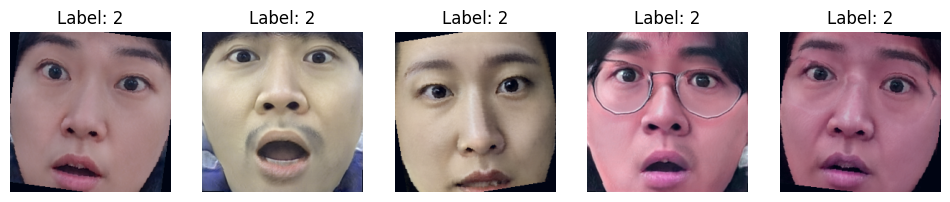

In [19]:
import matplotlib.pyplot as plt

# 데이터셋 시각화 함수
def visualize_dataset_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # 이미지 채널 변경 (C, H, W -> H, W, C)
        image = (image * 0.229 + 0.485).clip(0, 1)  # 정규화 해제 (mean/std 복원)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(label)}")
        plt.axis("off")
    plt.show()

# 샘플 시각화 (Train Dataset)
visualize_dataset_samples(train_dataset)


# 모바일넷

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetV3Net(nn.Module):
    def __init__(self, num_emotions=2, dropout_rate=0.2):
        super(MobileNetV3Net, self).__init__()
        # MobileNetV3-Small 백본
        self.backbone = models.mobilenet_v3_small(pretrained=True)

        # MobileNetV3의 분류기(classifier) 부분 제거
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Identity()

        # 간소화된 Fully Connected 레이어
        self.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(in_features, num_emotions)
        )

    def forward(self, x):
        features = self.backbone(x)  # MobileNet-V3 백본에서 특징 추출
        x = self.fc(features)       # 간소화된 Fully Connected 레이어
        return x

# MultiTaskGhostFaceNet

In [99]:
import torch
import torch.nn as nn
from ellzaf_ml.models import GhostFaceNetsV2

class MultiTaskGhostFaceNet(nn.Module):
    def __init__(self, image_size=112, num_emotions=4):
        super(MultiTaskGhostFaceNet, self).__init__()
        self.backbone = GhostFaceNetsV2(image_size=image_size, width=1, dropout=0.0)
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.fc_emotion = nn.Linear(128, num_emotions)

    def forward(self, x):
        features = self.backbone(x)
        x = self.fc1(features)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        emotion_out = self.fc_emotion(x)
        return emotion_out

/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# efficientnet_b0Net

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class efficientnet_b0Net(nn.Module):
    def __init__(self, num_emotions=4, dropout_rate=0.3):
        super(efficientnet_b0Net, self).__init__()

        # 백본 모델 정의
        self.backbone = models.efficientnet_b0(pretrained=True)
        # self.backbone = models.resnet50(pretrained=True)
 

        # Efficientnet의 분류기의 입력을 뽑아내는 코드
        in_features = self.backbone.classifier[1].in_features
        
        # ResNet50에서 최종 분류 레이어(fc)의 입력 특징 수를 가져옴
        # in_features = self.backbone.fc.in_features

        # 분류기를 사용하지 않을거기 때문에 빈 레이어를 정의해줌
        self.backbone.classifier = nn.Identity()
        

        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # Feature extraction from backbone
        features = self.backbone(x)
        
        x = self.fc(features)
        return x


# ConvNeXt

In [179]:
import torch
import torch.nn as nn
from timm import create_model

class EmotionClassifierNet_ConvNeXt(nn.Module):
    def __init__(self, num_emotions=4, dropout_rate=0.3):
        super(EmotionClassifierNet_ConvNeXt, self).__init__()

        # ConvNeXt Backbone
        self.backbone = create_model('convnext_base', pretrained=True)

        # ConvNeXt의 분류기 (head)의 입력 특징 수 가져오기
        in_features = self.backbone.head.fc.in_features

        # 기존 분류기를 Identity로 교체
        self.backbone.head.fc = nn.Identity()

        # 새로운 분류기 정의
        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # Backbone에서 특징 추출
        features = self.backbone(x)

        # 분류기로 감정 분류
        x = self.fc(features)
        return x


# EmotionClassifierNet_vit

In [12]:
import torch
import torch.nn as nn
from timm import create_model

class EmotionClassifierNet_vit(nn.Module):
    def __init__(self, num_emotions=4, dropout_rate=0.4):
        super(EmotionClassifierNet_vit, self).__init__()

        # ViT Backbone
        self.backbone = create_model('vit_large_patch16_384', pretrained=True)

        # Freeze all layers in the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Unfreeze the last 4 blocks
        for param in self.backbone.blocks[-4:].parameters():
            param.requires_grad = True

        # Remove classification head
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Identity()

        # Transform to 4D tensor for convolutional head
        self.conv_transform = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Unflatten(1, (in_features, 1, 1))  # [Batch, Features] -> [Batch, Features, 1, 1]
        )

        # Convolutional Head
        self.conv_head = nn.Conv2d(in_channels=in_features, out_channels=256, kernel_size=3, stride=1, padding=1)

        # Adaptive Pooling
        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Classification Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # Extract features from ViT backbone
        features = self.backbone(x)

        # Transform to 4D tensor
        transformed = self.conv_transform(features)

        # Apply Convolutional Head
        conv_features = self.conv_head(transformed)

        # Pool the features
        pooled_features = self.pooling(conv_features)

        # Flatten and apply classification head
        logits = self.fc(pooled_features)

        return logits

/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# swin_tiny

In [186]:
import torch
import torch.nn as nn
from timm import create_model

class EmotionClassifierNet_swin_tiny(nn.Module):
    def __init__(self, num_emotions=4, dropout_rate=0.3):
        super(EmotionClassifierNet_swin_tiny, self).__init__()

        # Swin Tiny Backbone
        self.backbone = create_model('swin_tiny_patch4_window7_224', pretrained=True)

        # Get input features of the head
        in_features = self.backbone.num_features  # Output feature size
        self.backbone.head = nn.Identity()  # Remove the classification head

        # Fully Connected Layers for Classification
        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),  # Match the output features of backbone
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_emotions)
        )

    def forward(self, x):
        # Backbone Feature Extraction
        features = self.backbone(x)  # Swin Tiny's output: [Batch, Seq_Length, Features]

        # Global Average Pooling to reduce Seq_Length
        pooled_features = features.mean(dim=1)  # [Batch, Features]

        # Fully Connected Layers
        x = self.fc(pooled_features)  # [Batch, num_emotions]
        return x


# Memory Deletion

In [149]:
import gc
import torch

# # 불필요한 변수 삭제
del model
del optimizer
del train_data_loader
del val_data_loader
gc.collect()

# # GPU 메모리 해제
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

# Train

In [6]:
import torch
import torch.optim as optim
from tqdm import tqdm
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
# 손실 함수 정의
# class_weights = torch.tensor([2.0, 1.0, 1.0, 1.0]).to(device)  # 가중치 텐서를 CUDA로 이동
# emotion_criterion = nn.CrossEntropyLoss(weight=class_weights)
emotion_criterion = nn.CrossEntropyLoss()

# 모델 초기화
model = MobileNetV3Net(num_emotions=2)
# model.load_state_dict(torch.load(f"/workspace/daewoong/face_recognition_emotions/model/{type(model).__name__}_best_emotion_classifier.pth"))
model = model.to(device)

# Optimizer 설정
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])
# Scheduler 초기화
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Hyperparameters
num_epochs = 10
best_val_loss = float('inf')  # Validation loss 추적

# 학습 루프
for epoch in range(num_epochs):
    # Training 단계
    model.train()
    running_loss = 0.0
    correct_emotions = 0
    total_samples = 0

    train_loader_tqdm = tqdm(train_data_loader, desc=f"Emotion Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, emotions in train_loader_tqdm:
        images, emotions = images.to(device), emotions.to(device)
        emotion_out = model(images)

        loss_emotion = emotion_criterion(emotion_out, emotions)
        _, emotion_pred = torch.max(emotion_out, 1)
        correct_emotions += (emotion_pred == emotions).sum().item()
        total_samples += emotions.size(0)

        optimizer.zero_grad()
        loss_emotion.backward()
        optimizer.step()

        running_loss += loss_emotion.item()
        train_loader_tqdm.set_postfix(loss=loss_emotion.item())

    accuracy = 100 * correct_emotions / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Emotion Loss: {running_loss / len(train_data_loader):.4f}, Accuracy: {accuracy:.2f}%")


    # Validation 단계
    model.eval()
    val_loss = 0.0
    correct_emotions = 0
    total_samples = 0

    val_loader_tqdm = tqdm(val_data_loader, desc=f"Validation", unit="batch")
    with torch.no_grad():
        for images, emotions in val_loader_tqdm:
            images, emotions = images.to(device), emotions.to(device)
            emotion_out = model(images)

            loss_emotion = emotion_criterion(emotion_out, emotions)
            _, emotion_pred = torch.max(emotion_out, 1)
            correct_emotions += (emotion_pred == emotions).sum().item()
            total_samples += emotions.size(0)

            val_loss += loss_emotion.item() * images.size(0)

        avg_val_loss = val_loss / total_samples
        accuracy = 100 * correct_emotions / total_samples
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}% ({correct_emotions}/{total_samples})")

        # Best 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"/workspace/daewoong/face_recognition_emotions/model/{type(model).__name__}_best_emotion_classifier.pth")
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")
    scheduler.step(avg_val_loss)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Test

In [23]:
# 테스트 데이터 로더에서 첫 번째 배치 확인
for images, emotions in train_data_loader:
    # 입력 텐서와 라벨 확인
    print("Input tensor shape:", images.shape)
    print("Input tensor device:", images.device)
    print("Labels shape:", emotions.shape)
    print("Labels device:", emotions.device)
    break

Input tensor shape: torch.Size([16, 3, 224, 224])
Input tensor device: cpu
Labels shape: torch.Size([16])
Labels device: cpu


In [36]:
from sklearn.metrics import classification_report
model = MobileNetV3Net(num_emotions=4)
model = model.to(device)

# 모델 로드
model.load_state_dict(torch.load(f"/workspace/daewoong/face_recognition_emotions/model/{type(model).__name__}_best_emotion_classifier.pth"))
print(f"{type(model).__name__} model loaded for testing")

# 테스트 모드로 설정
model.eval()
test_loss = 0.0
all_emotions = []
all_predictions = []

test_loader_tqdm = tqdm(test_data_loader, desc=f"Test", unit="batch")
correct_emotions = 0
total_samples = 0

with torch.no_grad():
    for images, emotions in test_loader_tqdm:
        images, emotions = images.to(device), emotions.to(device)
        
        emotion_out = model(images)

        loss_emotion = emotion_criterion(emotion_out, emotions)

        _, emotion_pred = torch.max(emotion_out, 1)
        correct_emotions += (emotion_pred == emotions).sum().item()
        total_samples += emotions.size(0)

        test_loss += loss_emotion.item() * images.size(0)  

        if total_samples % (10 * images.size(0)) == 0:
            test_loader_tqdm.set_postfix(loss=loss_emotion.item(), accuracy=correct_emotions / total_samples)

        all_emotions.extend(emotions.cpu().numpy())
        all_predictions.extend(emotion_pred.cpu().numpy())

if total_samples > 0:
    avg_test_loss = test_loss / total_samples
    accuracy = 100 * correct_emotions / total_samples
    print(f"Test Loss: {avg_test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}% ({correct_emotions}/{total_samples})")
    target_names = [f"Class {i}" for i in range(2)]  # 클래스 이름 (0~3)
    report = classification_report(all_emotions, all_predictions, target_names=target_names)
    print("\nClassification Report:")
    print(report)
else:
    print("Test set is empty!")


/tmp/ipykernel_338472/3647712506.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/workspace/daewoong/face_recognition_emotions/model/{

MobileNetV3Net model loaded for testing


Test: 100%|██████████| 39/39 [00:02<00:00, 13.86batch/s, accuracy=0.892, loss=0.258] 

Test Loss: 0.2604, Accuracy: 89.34% (553/619)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.88      0.89       312
     Class 1       0.88      0.91      0.89       307

    accuracy                           0.89       619
   macro avg       0.89      0.89      0.89       619
weighted avg       0.89      0.89      0.89       619



# Test

# Real Image Test

In [117]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
model = type(model)(num_emotions=4)
model.load_state_dict(torch.load(f"/workspace/daewoong/face_recognition_emotions/model/{type(model).__name__}_emotion_classifier.pth"))  # 학습된 모델 가중치 파일 경로
model = model.to(device)
model.eval()

def predict_emotion(image_path, model):
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    metadata_file = "/workspace/daewoong/face_recognition_emotions/combined_label/combined.json"
    
    # with open(metadata_file, 'r', encoding='EUC-KR') as f:
    #     metadata = json.load(f)
    # img_name = image_path.split("/")[-1]

    # metadata_filtered = [element for element in metadata if element['filename'] == img_name]

    # if len(metadata_filtered) != 0:
    #     box_info = metadata_filtered[0]["annot_B"]["boxes"]
    #     image = crop_image(image, box_info)
        
    image = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 및 GPU 이동

    # 모델 예측
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()  # 가장 높은 확률의 클래스 반환

    return predicted_class

# 이미지 경로
image_path = "/workspace/daewoong/data_cropped/test/happy/a9iucfa86b8d461491bd5cabcbdf12c88fdd11f1d2894f621aaa012212ebddd3p_face_0.jpg"  # 예측할 이미지 파일 경로

# 예측 수행
predicted_class = predict_emotion(image_path, model)
emotion_classes = ["anger", "happy", "panic", "sad"]  # 감정 클래스 리스트 (예시)
print(f"Predicted Emotion: {emotion_classes[predicted_class]}")

/tmp/ipykernel_24786/1735498259.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/workspace/daewoong/face_recognition_emotions/model/{t

Predicted Emotion: happy
